In [7]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.6/799.6 kB 30.2 MB/s eta 0:00:00


In [8]:
from IPython import display
display.clear_output()
from IPython.display import display, Image

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

import shutil
import os

import yaml
import cv2
import matplotlib.pyplot as plt

import random

Ultralytics YOLOv8.2.51 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.3/8062.4 GB disk)


# Screw Detection

In this section, I will use the dataset named "screw-and-bolt-detection" that I created earlier. I will use YOLOv5 for the detection purposes.

## dataset

In [9]:
DATA_PATH = "/kaggle/input/screw-and-bolt-detection/screw-bolt-detection"

### prep config yaml

In [10]:
cfg = {
    "path": "../../input/screw-and-bolt-detection/screw-bolt-detection",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 2,
    "names": ["screw", "bolt"]
}
    
with open("/kaggle/working/data.yaml", "w") as f:
    cfg = yaml.dump(
        cfg, stream=f, default_flow_style=False, sort_keys=False
    )

### samples from the dataset

(640, 640, 3)


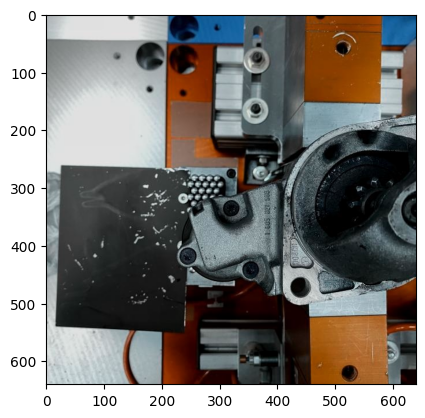

In [11]:
image_path = random.choice(os.listdir(f"{DATA_PATH}/train/images"))
image = cv2.imread(f"{DATA_PATH}/train/images/{image_path}")
print(image.shape)
plt.imshow(image)

In [12]:
for split in ["train", "test", "val"]:
    print(f"Number of samples in the {split} set:", len(os.listdir(f"{DATA_PATH}/{split}/images")))

Number of samples in the train set: 951
Number of samples in the test set: 204
Number of samples in the val set: 205


## training

In [13]:
EPOCH = 50
BATCH = 16
IMAGE_SIZE = 640

In [14]:
!yolo \
task=detect \
mode=train \
model=yolov5su.pt \
data=/kaggle/working/data.yaml \
epochs=$EPOCH \
batch=$BATCH \
imgsz=$IMAGE_SIZE \
plots=True \
val=True \
overlap_mask=False \
mask_ratio=0 \
translate=0.0 \
fliplr=0.5 \
mixup=0.0 \
copy_paste=0.0 \
close_mosaic=50 \
device=0,1

100%|███████████████████████████████████████| 17.7M/17.7M [00:00<00:00, 226MB/s]
Ultralytics YOLOv8.2.51 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=(0, 1), workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=50, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=False, mask_ratio=0, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

### Results

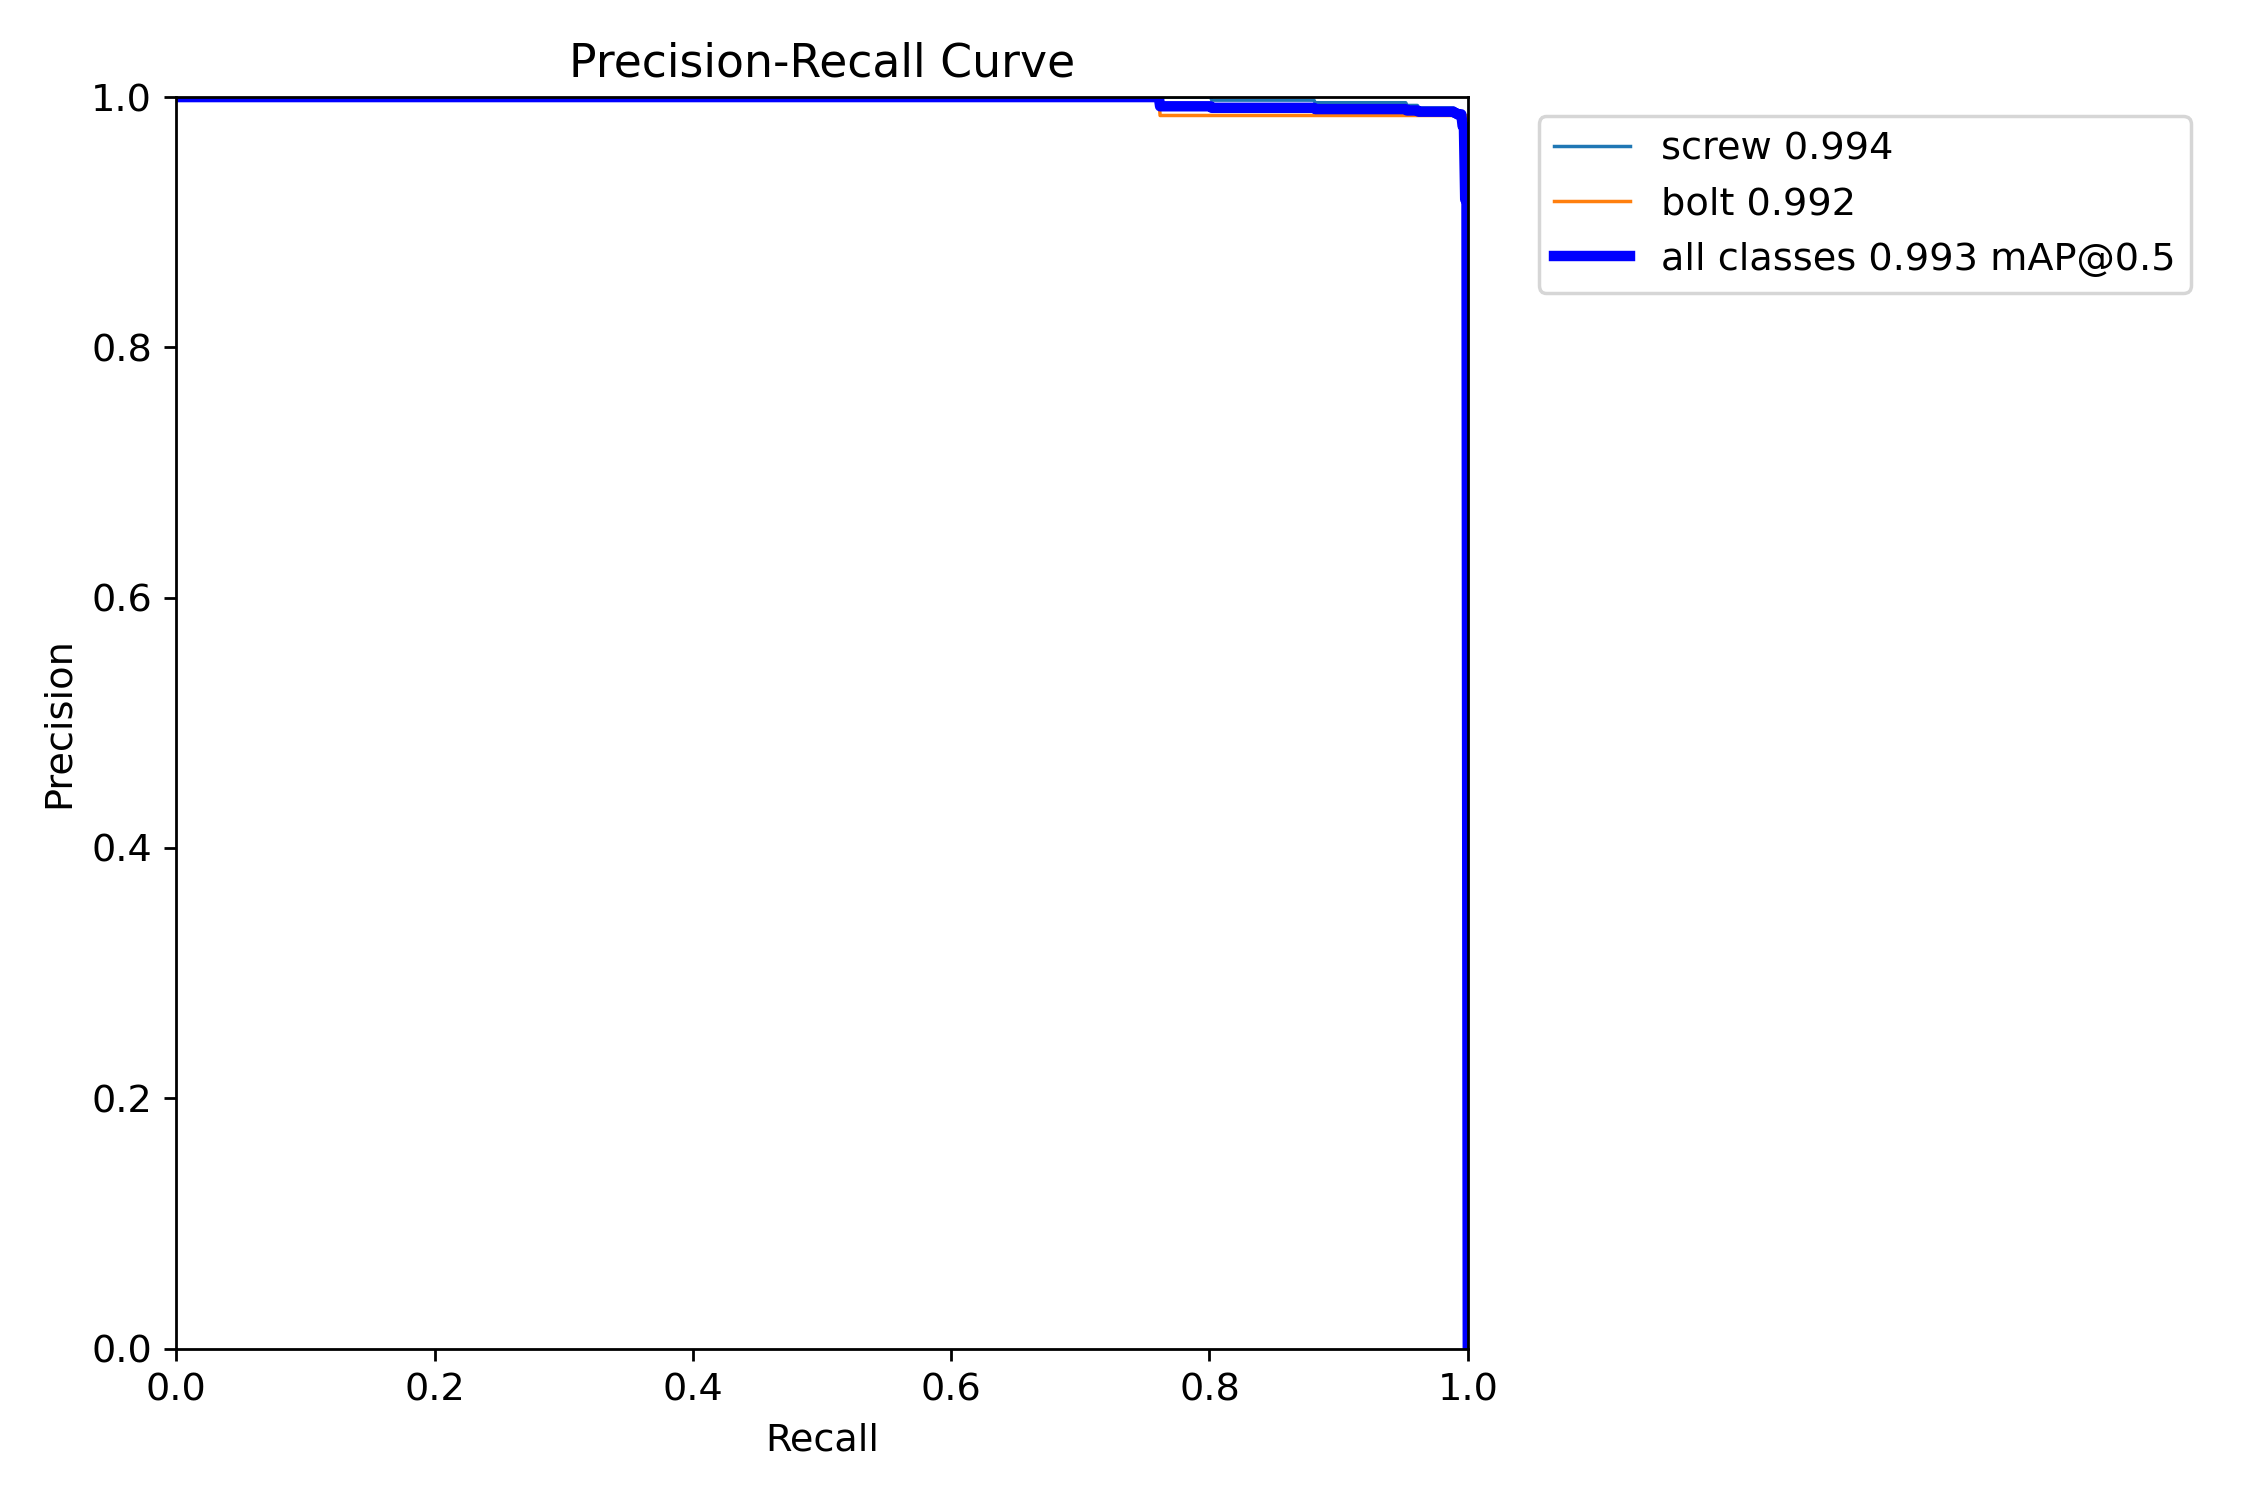

In [16]:
Image(filename='./runs/detect/train/PR_curve.png', width=800)

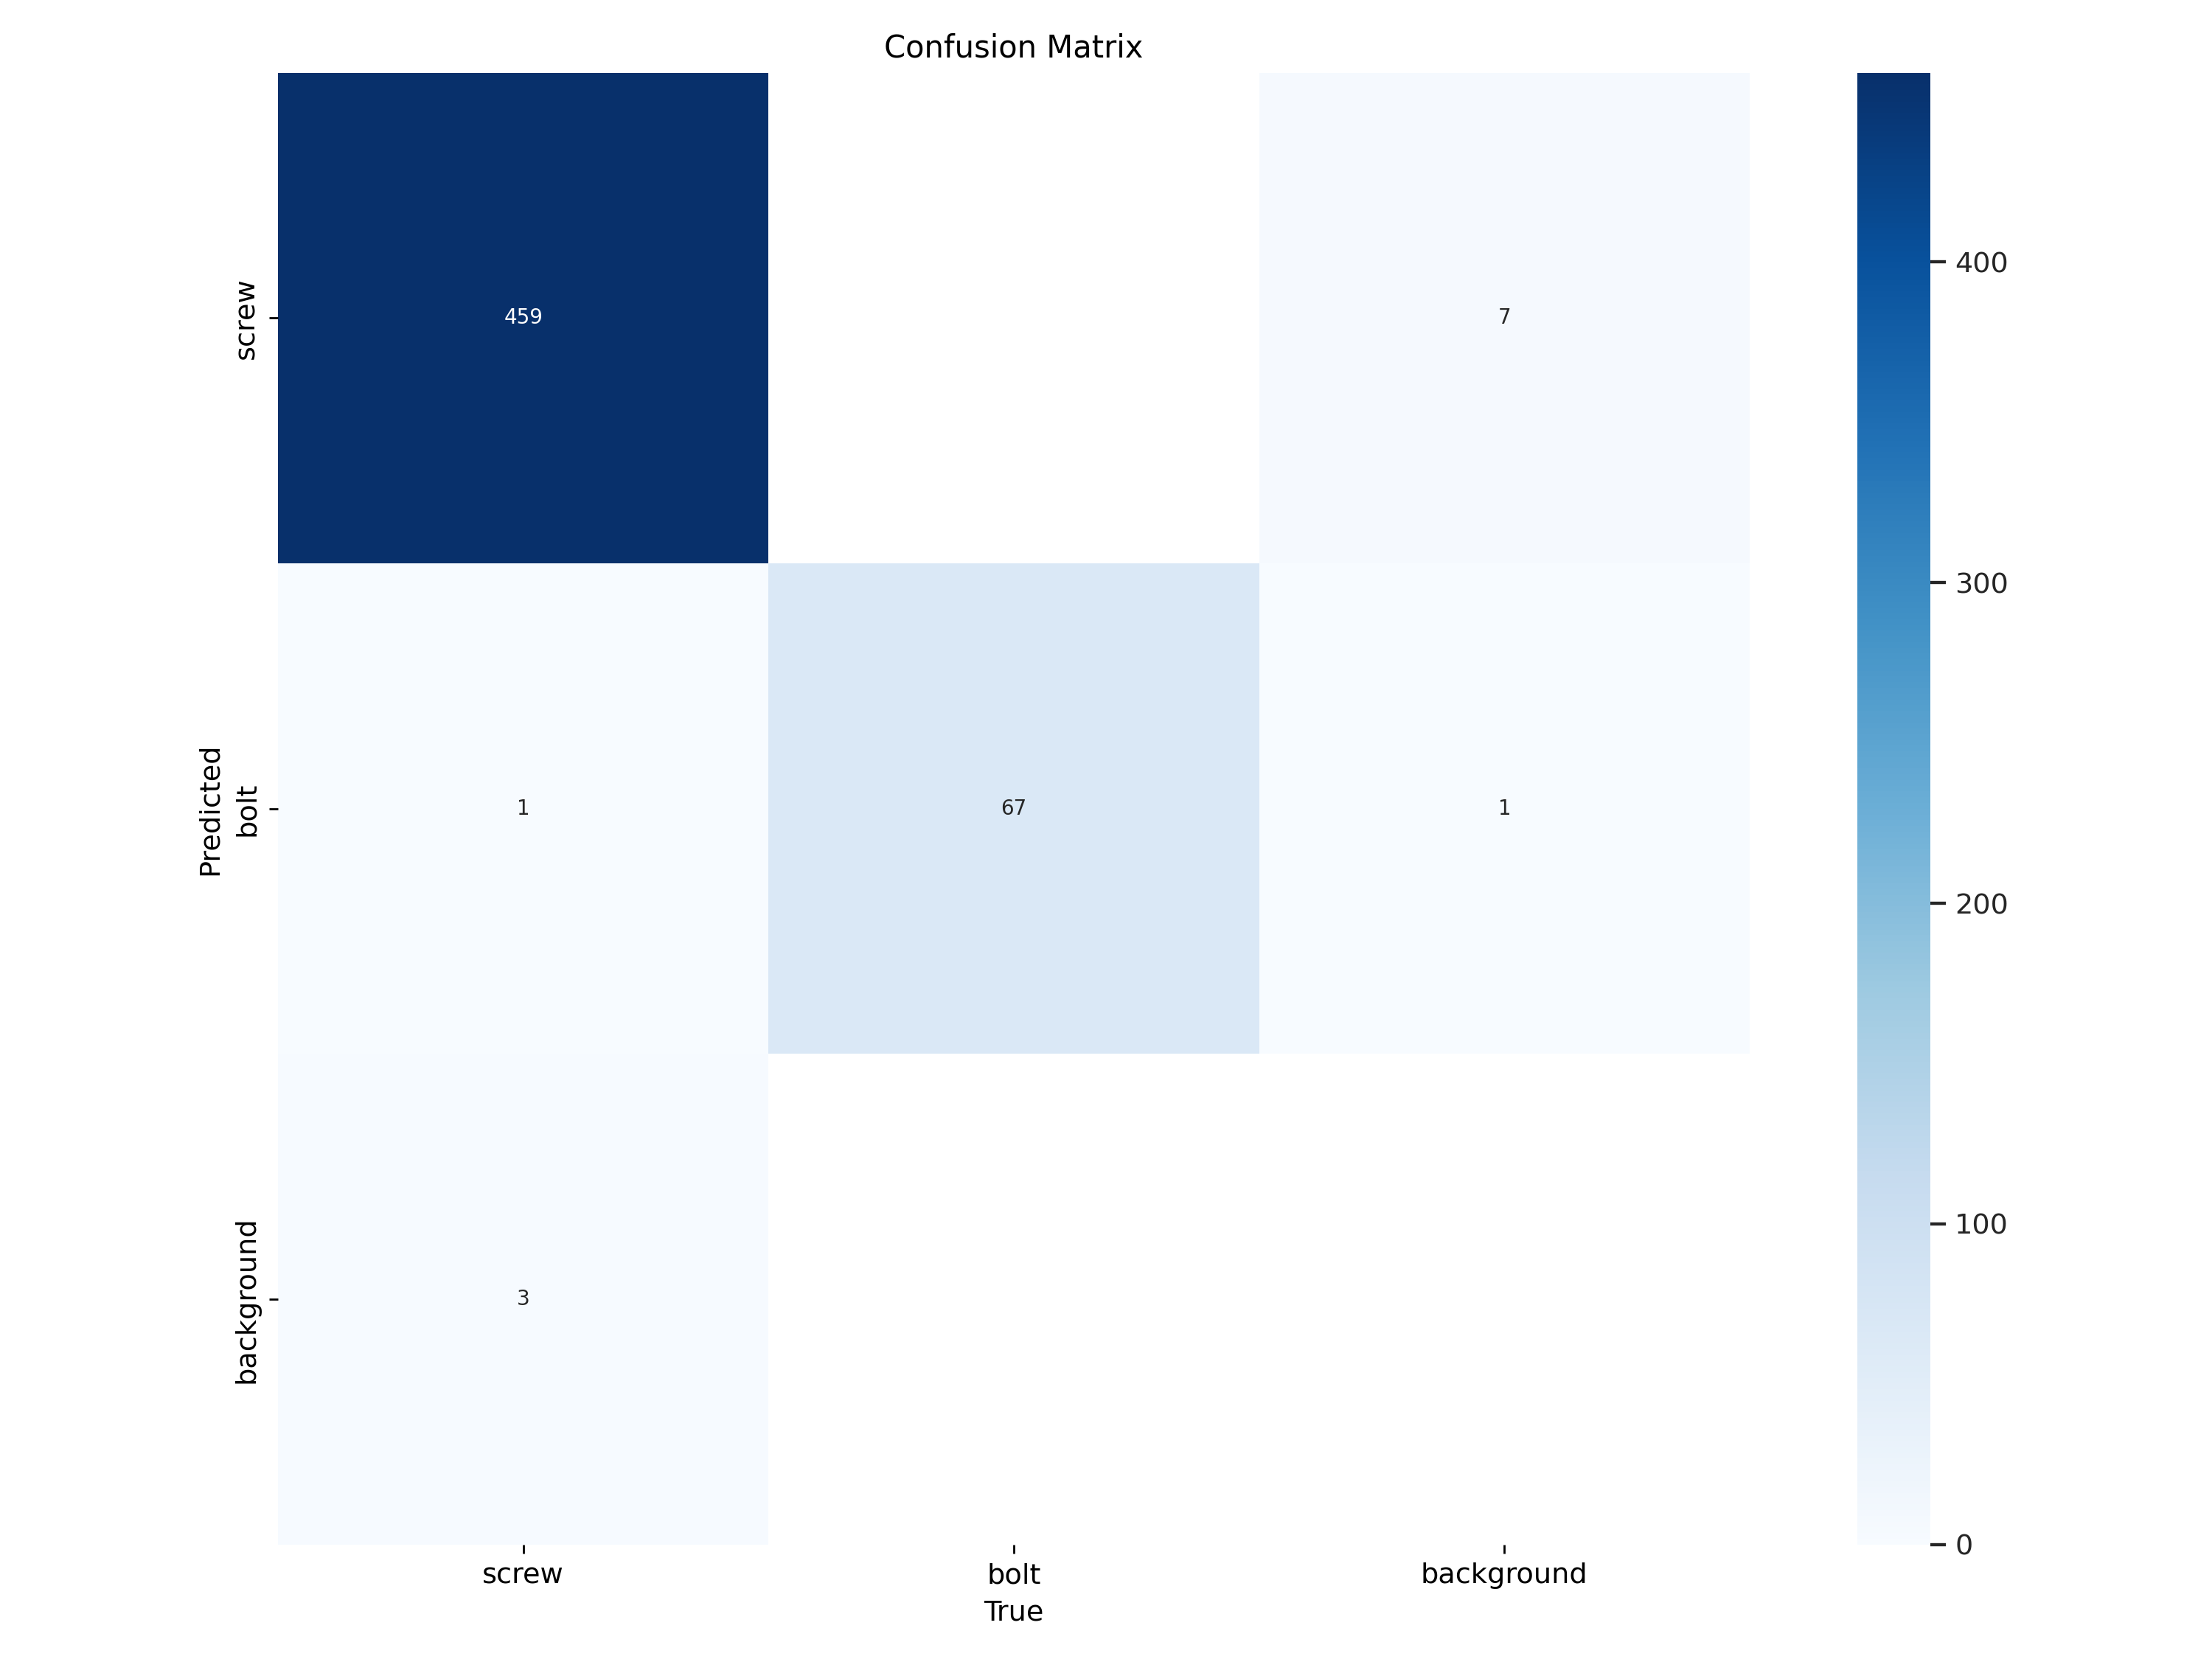

In [17]:
Image(filename='./runs/detect/train/confusion_matrix.png', width=800)

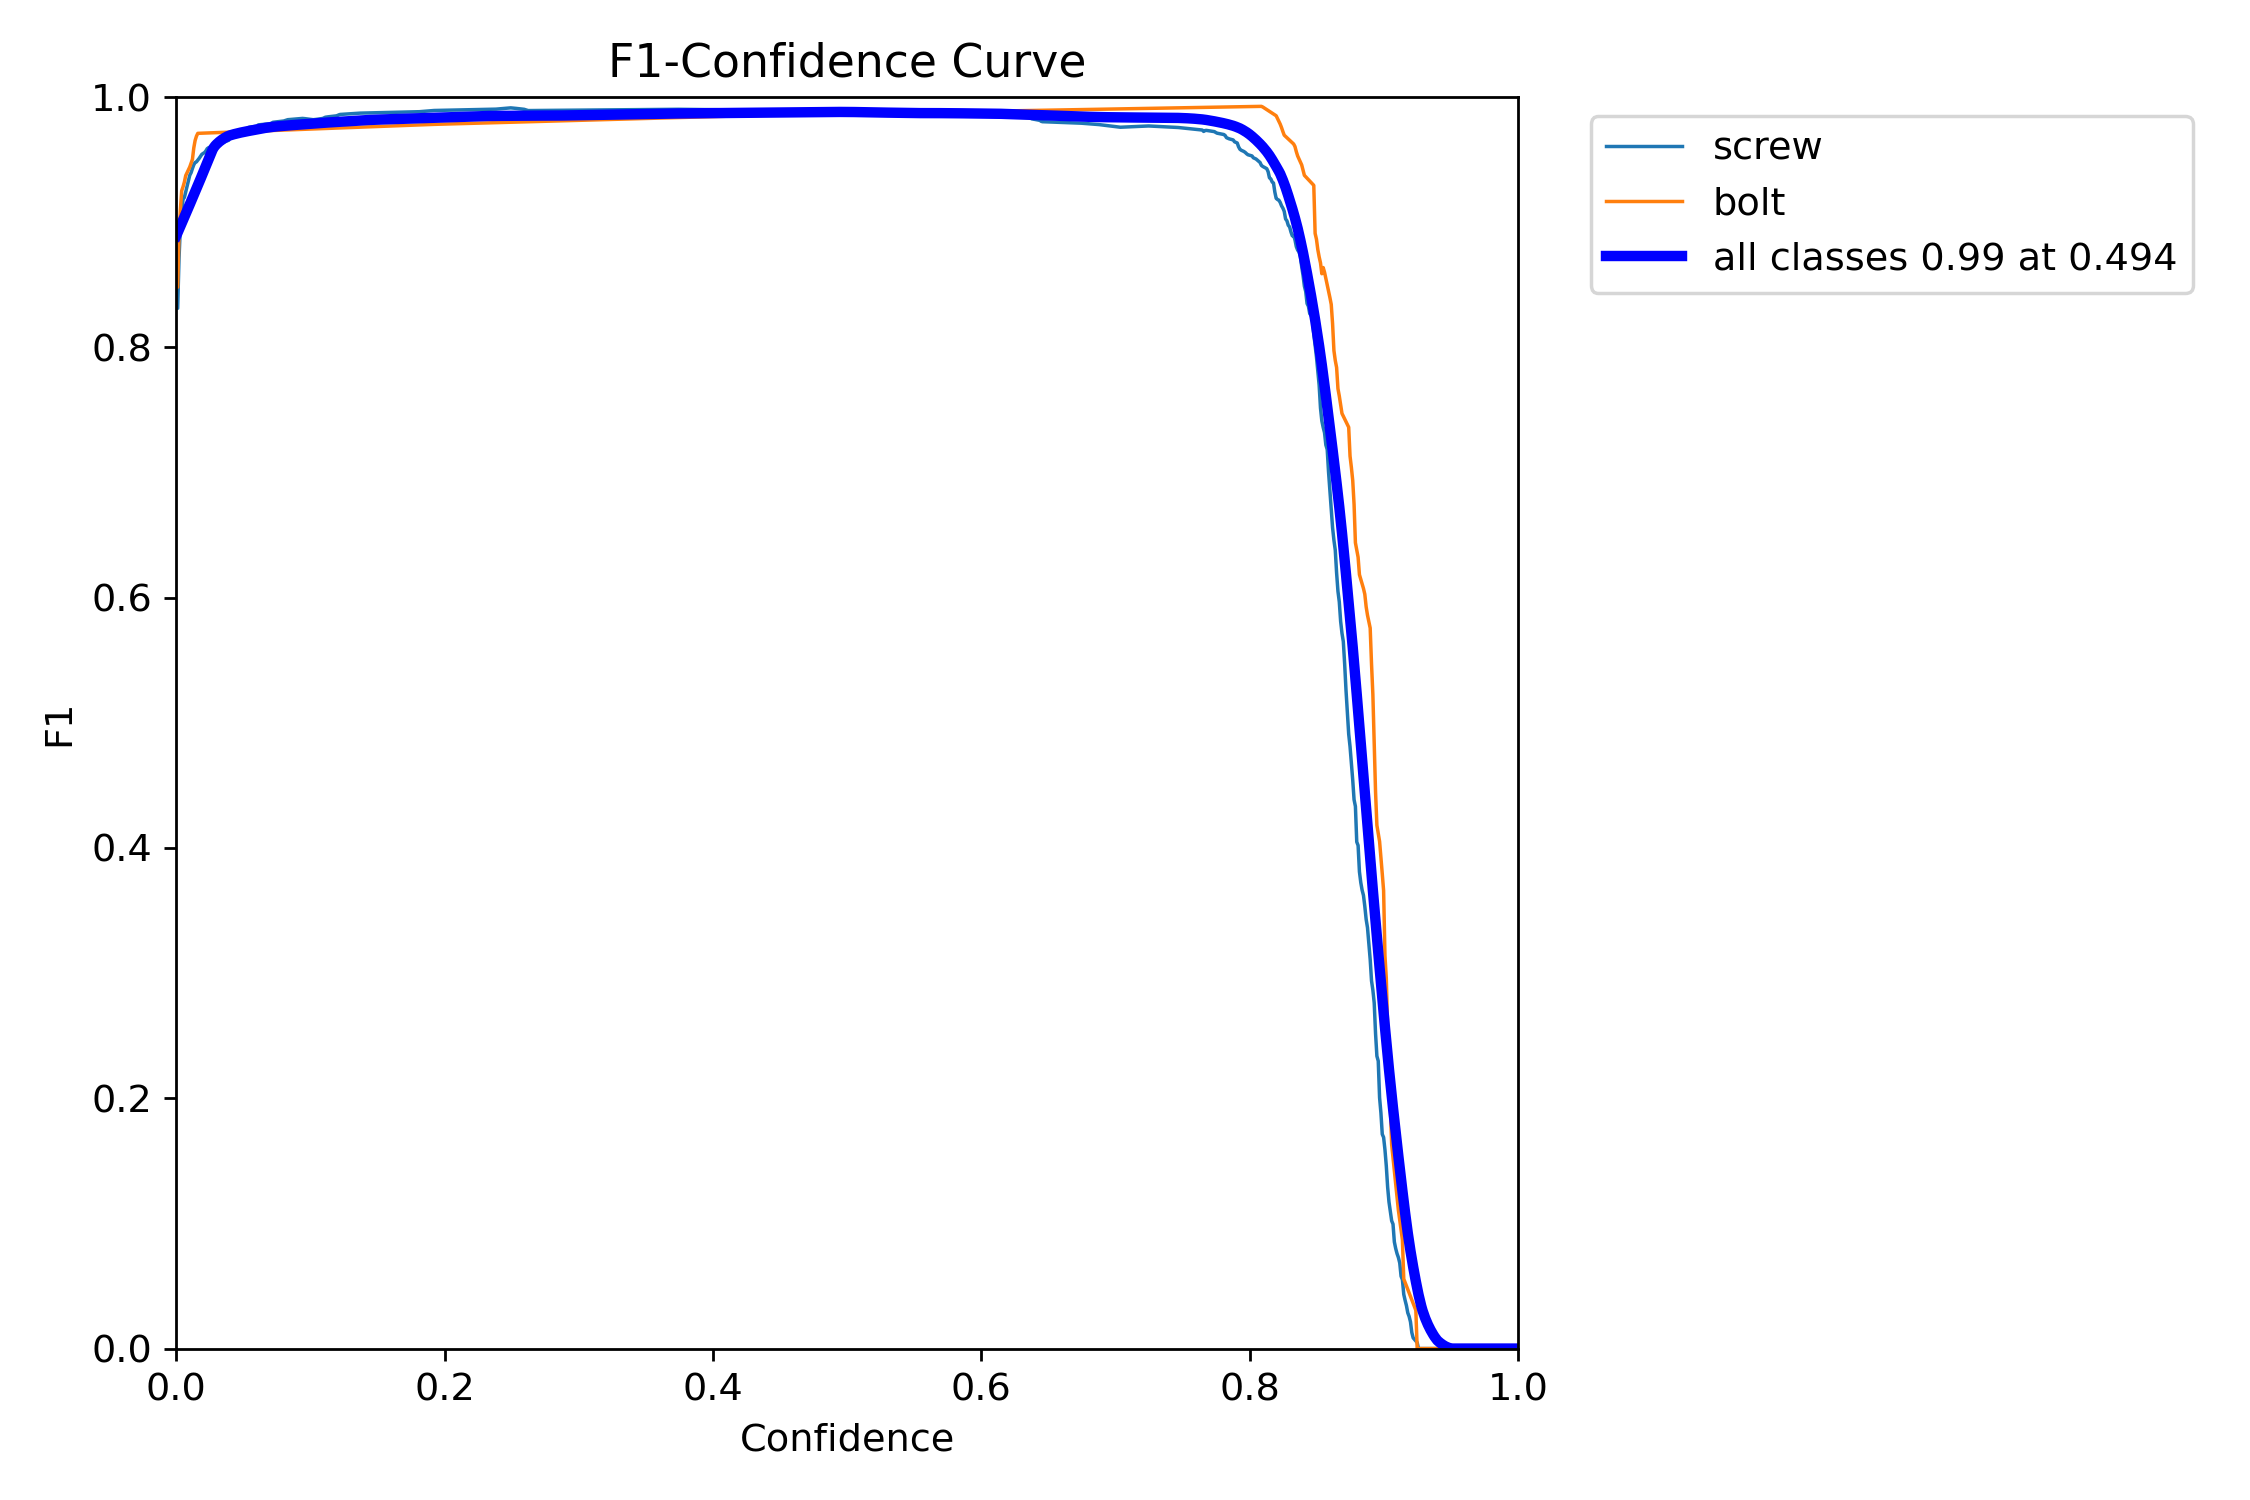

In [18]:
Image(filename='./runs/detect/train/F1_curve.png', width=800)

### eval

In [20]:
!yolo \
task=detect \
mode=val \
model=/kaggle/working/runs/detect/train/weights/best.pt \
data=/kaggle/working/data.yaml \
iou=0.5 \
conf=0.8 \
imgsz=640 \
device=0,1 \
plots=True \
agnostic_nms=True

Ultralytics YOLOv8.2.51 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 193 layers, 9112310 parameters, 0 gradients, 23.8 GFLOPs
val: Scanning /kaggle/input/screw-and-bolt-detection/screw-bolt-detection/val/la
val: WARNING ⚠️ Cache directory /kaggle/input/screw-and-bolt-detection/screw-bolt-detection/val is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        205        530       0.99      0.957      0.974       0.79
                 screw        199        463      0.995      0.914      0.956      0.769
                  bolt         40         67      0.985          1      0.992      0.811
Speed: 1.3ms preprocess, 8.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


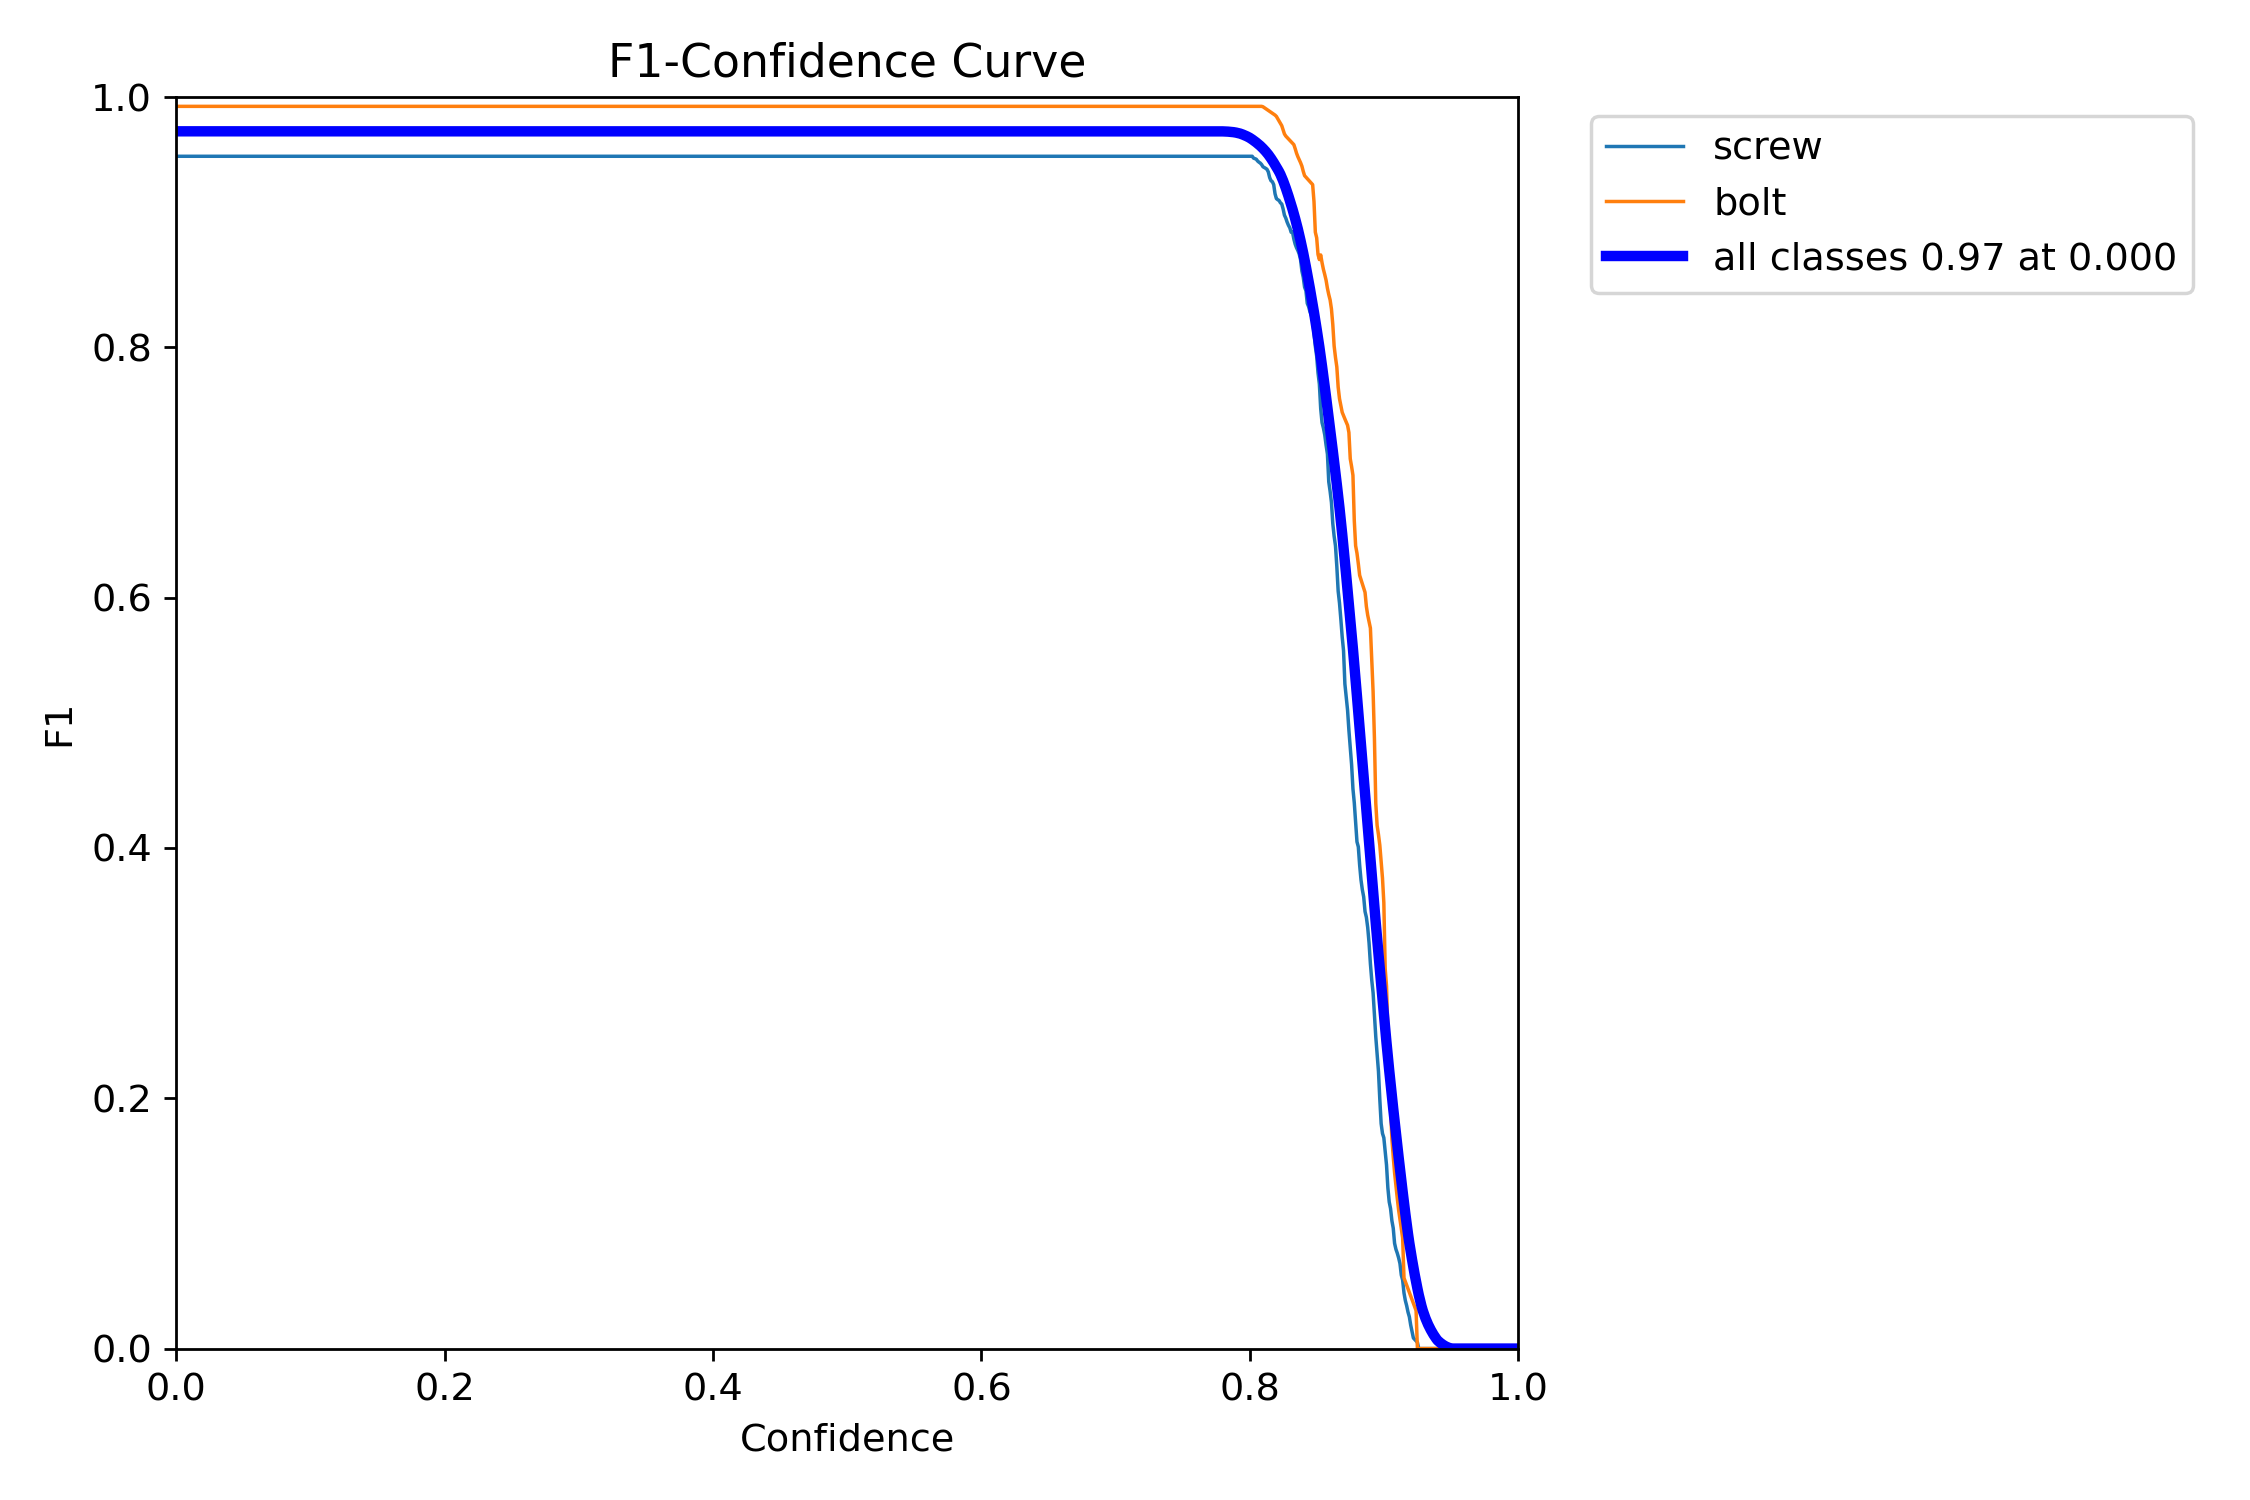

In [21]:
Image(filename='./runs/detect/val/F1_curve.png', width=800)

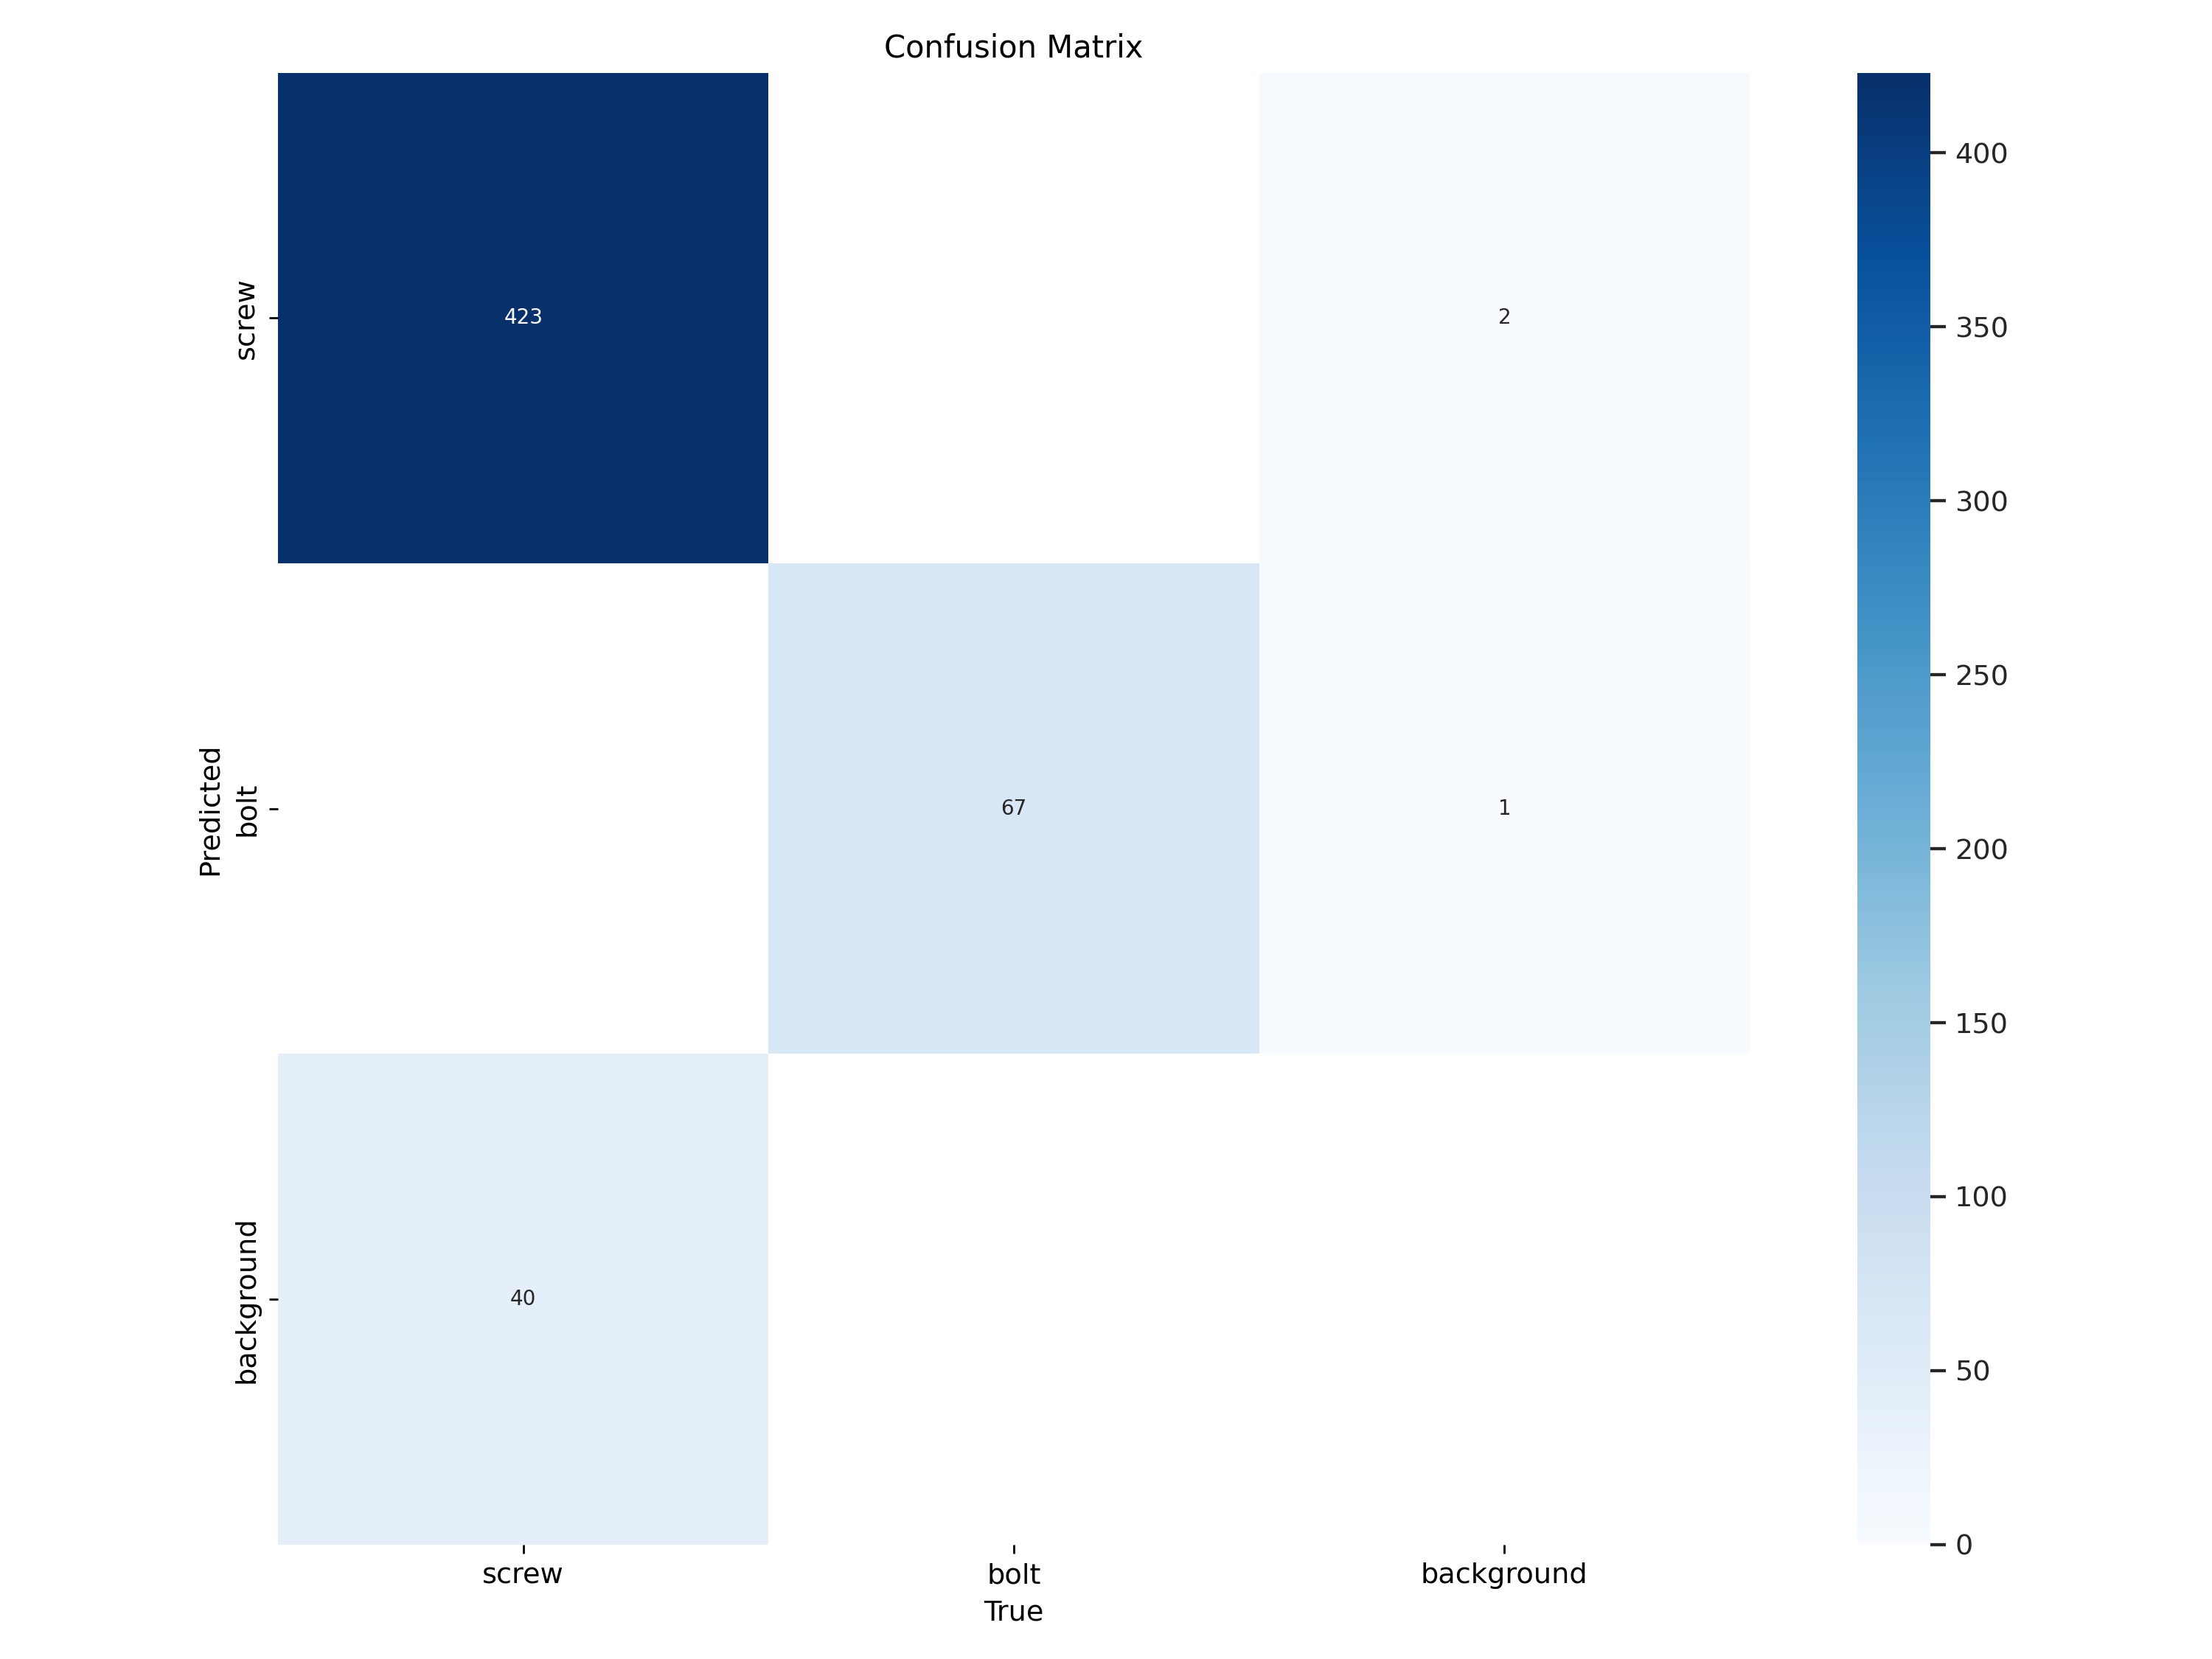

In [22]:
Image(filename='./runs/detect/val/confusion_matrix.png', width=800)

# Screw Classification

## dataset

In [23]:
DATA_PATH = "/kaggle/input/screw-and-bolt-classification/screw-classification/"

### classes

In [24]:
classes = os.listdir(f"{DATA_PATH}/train")
num_classes = len(classes)
print(classes)

['Torx_Screw', 'Pozidriv_Screw', 'Philips_Screw', 'Hex_Washer_Screw', 'Flat_Head_Screw']


### samples from the dataset

(16, 16, 3)


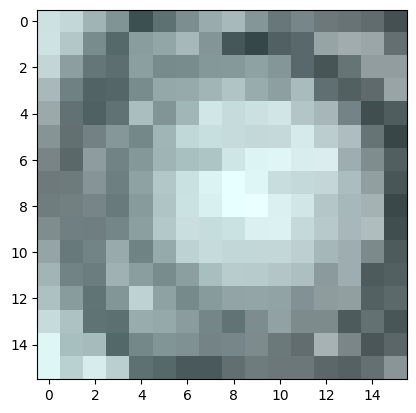

In [25]:
sample_class = random.choice(classes)
image_path = random.choice(os.listdir(f"{DATA_PATH}/train/{sample_class}"))
image = cv2.imread(f"{DATA_PATH}/train/{sample_class}/{image_path}")
print(image.shape)
plt.imshow(image)

In [26]:
for split in ["train", "test", "val"]:
    print(f"Number of samples in the {split} set:")
    for class_name in classes:
        print(f"\t {class_name}:", len(os.listdir(f"{DATA_PATH}/{split}/{class_name}")))
    print("\n")

Number of samples in the train set:
	 Torx_Screw: 785
	 Pozidriv_Screw: 455
	 Philips_Screw: 460
	 Hex_Washer_Screw: 401
	 Flat_Head_Screw: 28


Number of samples in the test set:
	 Torx_Screw: 168
	 Pozidriv_Screw: 97
	 Philips_Screw: 99
	 Hex_Washer_Screw: 86
	 Flat_Head_Screw: 6


Number of samples in the val set:
	 Torx_Screw: 169
	 Pozidriv_Screw: 98
	 Philips_Screw: 99
	 Hex_Washer_Screw: 87
	 Flat_Head_Screw: 6




## training

In [27]:
EPOCH = 50
BATCH = 64
IMAGE_SIZE = 32

In [28]:
!yolo \
task=classify \
mode=train \
model=yolov8s-cls.pt \
data=/kaggle/input/screw-and-bolt-classification/screw-classification \
epochs=$EPOCH \
batch=$BATCH \
imgsz=$IMAGE_SIZE \
plots=True \
val=True \
overlap_mask=False \
mask_ratio=0 \
translate=0.0 \
fliplr=0.5 \
mixup=0.0 \
copy_paste=0.0 \
close_mosaic=50 \
device=0,1

Ultralytics YOLOv8.2.51 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/kaggle/input/screw-and-bolt-classification/screw-classification, epochs=50, time=None, patience=100, batch=64, imgsz=32, save=True, save_period=-1, cache=False, device=(0, 1), workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=50, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=False, mask_ratio=0, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

## eval

In [29]:
!yolo \
task=classify \
mode=val \
model=/kaggle/working/runs/classify/train/weights/best.pt \
data=/kaggle/input/screw-and-bolt-classification/screw-classification \
iou=0.5 \
conf=0.8 \
imgsz=32 \
device=0,1 \
plots=True \
agnostic_nms=True

Ultralytics YOLOv8.2.51 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 73 layers, 5081605 parameters, 0 gradients, 12.5 GFLOPs
train: /kaggle/input/screw-and-bolt-classification/screw-classification/train... found 2129 images in 5 classes ✅ 
val: /kaggle/input/screw-and-bolt-classification/screw-classification/val... found 459 images in 5 classes ✅ 
test: /kaggle/input/screw-and-bolt-classification/screw-classification/test... found 456 images in 5 classes ✅ 
val: Scanning /kaggle/input/screw-and-bolt-classification/screw-classification/v
val: WARNING ⚠️ /kaggle/input/screw-and-bolt-classification/screw-classification/val/Torx_Screw/3_IMG_E8390_JPG.rf.deb7f8d61f3e3164a19d9fdba677607e.jpg: ignoring corrupt image/label: image size (10, 9) <10 pixels
val: WARNING ⚠️ Cache directory /kaggle/input/screw-and-bolt-classification/screw-classification is not writeable, cache 

In [34]:
!ls ./runs/classify/val

confusion_matrix.png		 val_batch0_pred.jpg	val_batch2_labels.jpg
confusion_matrix_normalized.png  val_batch1_labels.jpg	val_batch2_pred.jpg
val_batch0_labels.jpg		 val_batch1_pred.jpg


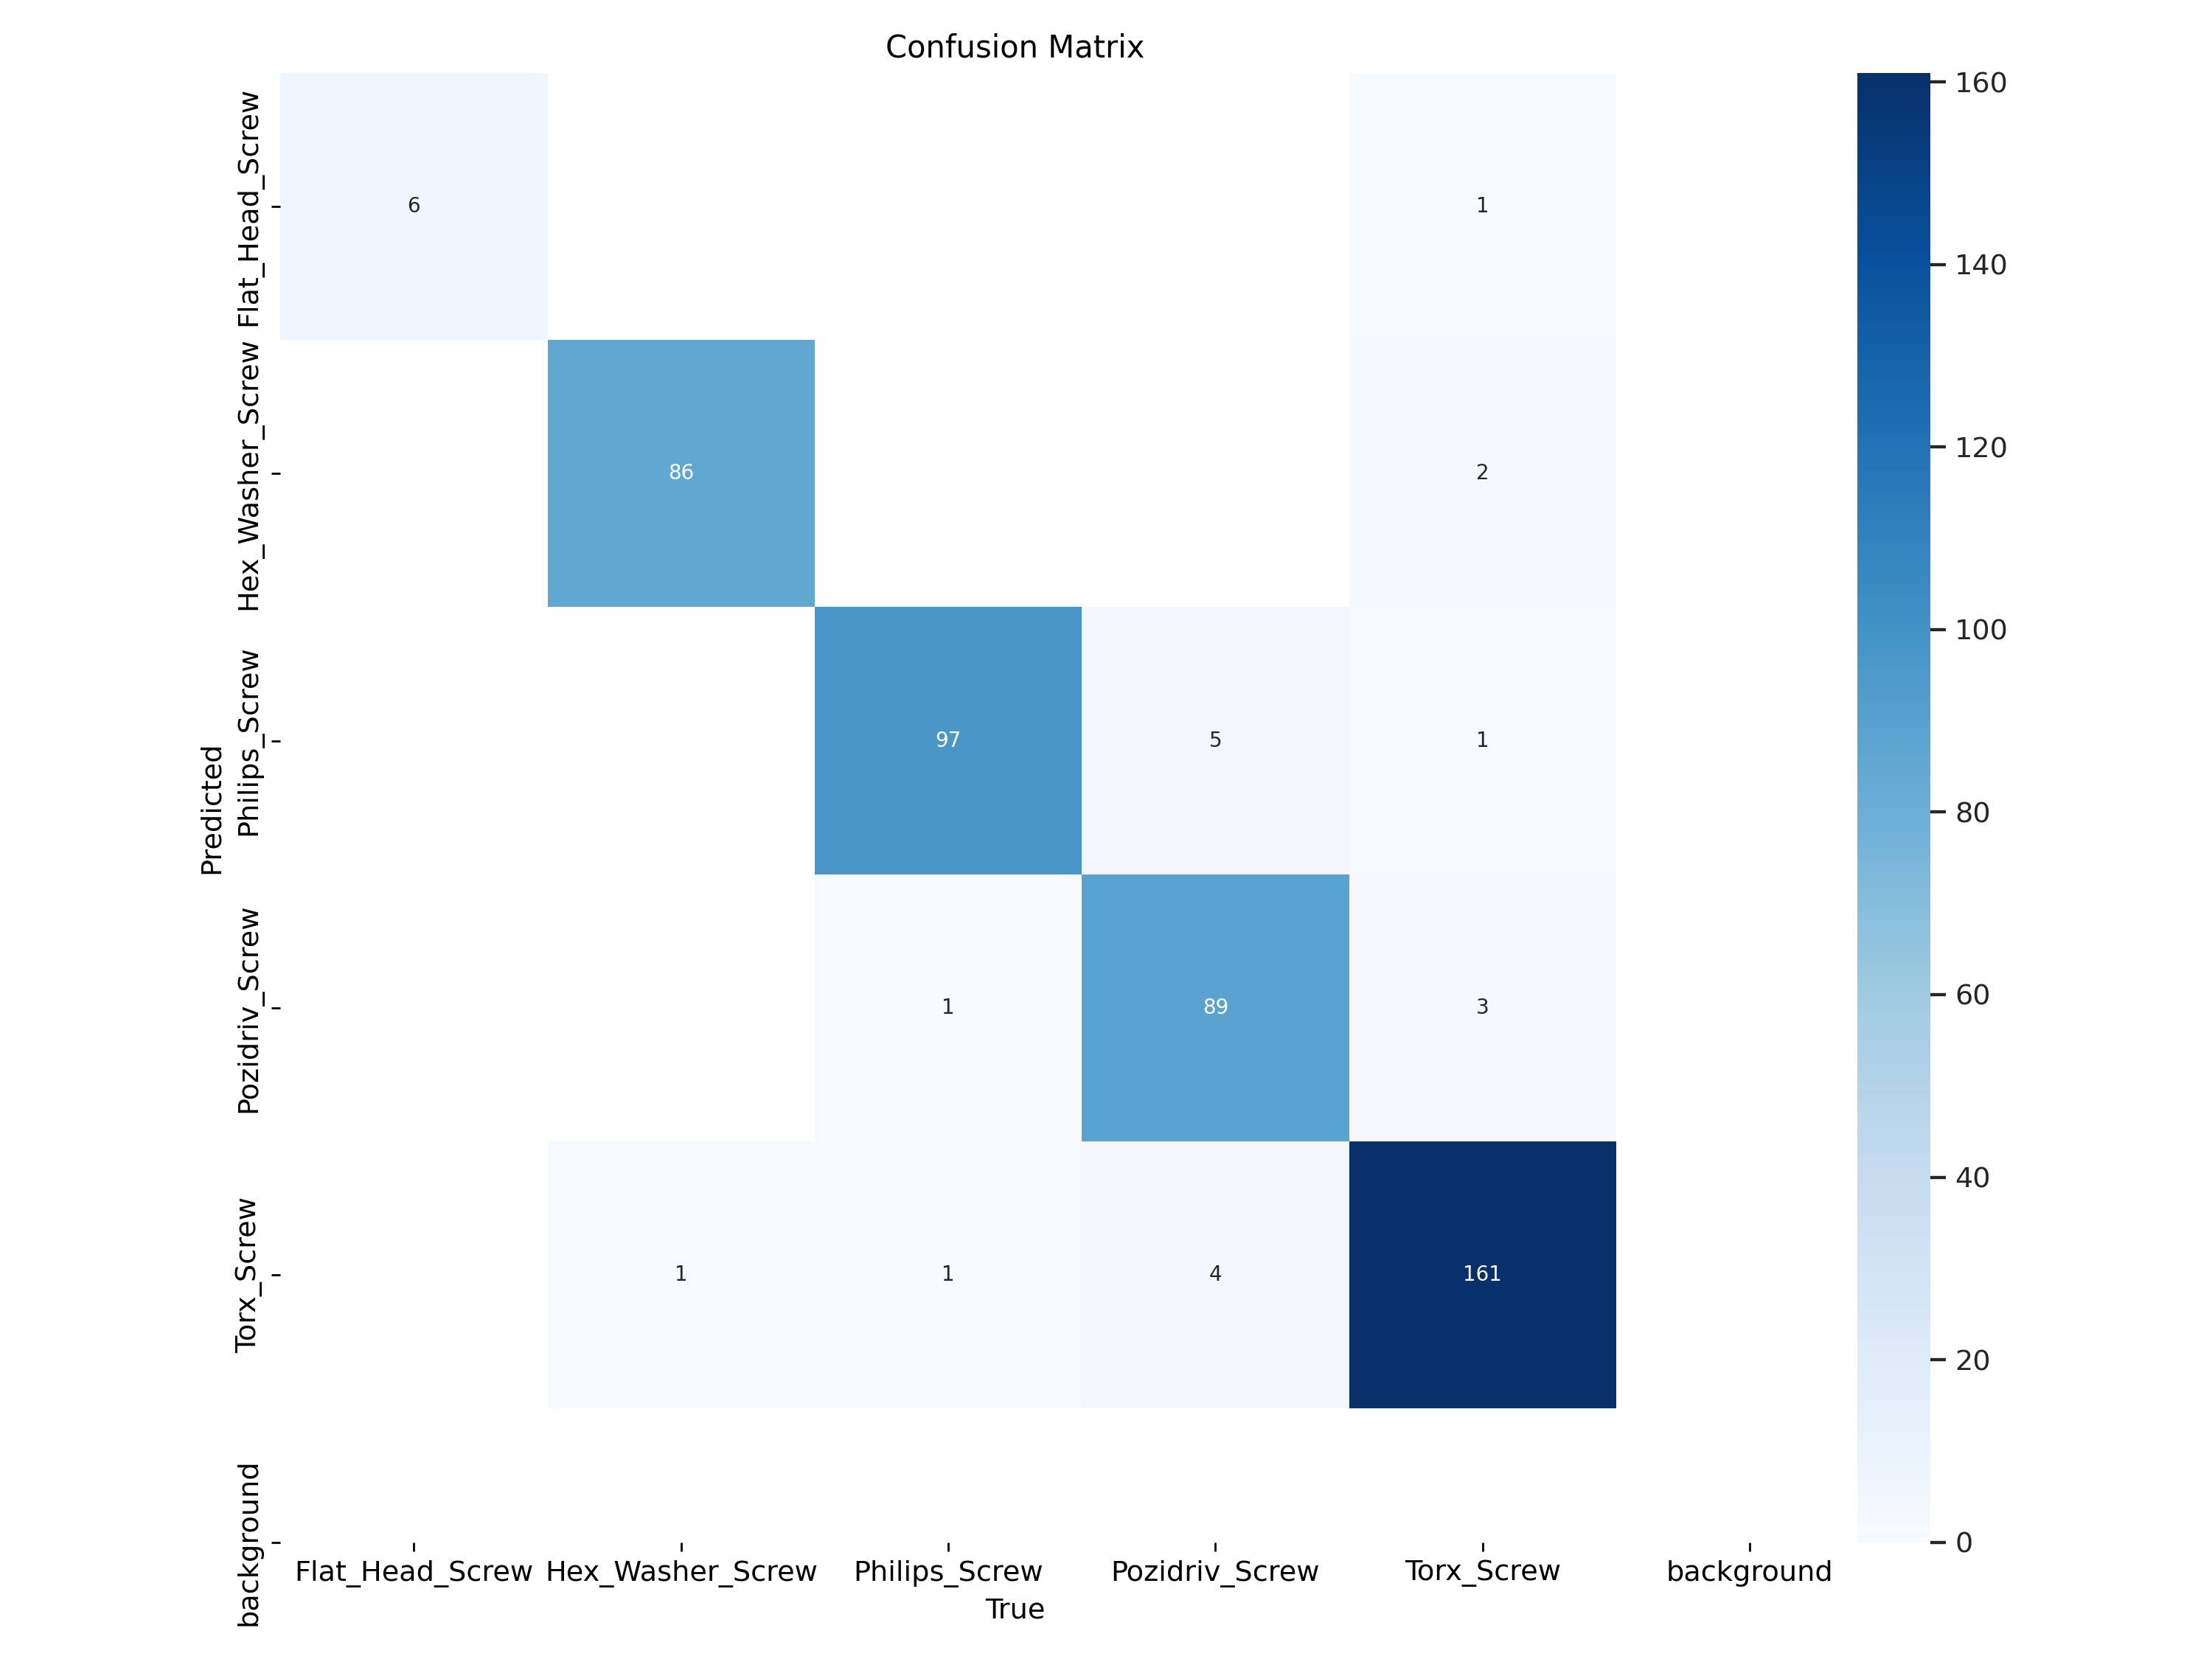

In [31]:
Image(filename='./runs/classify/val/confusion_matrix.png', width=800)